# Linear Regression Models for Exchange Rate Regimes

The Chinese Yuan was pegged to the US Dollar prior to July 2005. Then, China announced that the exchange rate would be set with reference to a basket of other currencies, allowing for a movement of up to 0.3% movement within any given day. The actual currencies and their basket weights were, however, unannounced by China.


In this study, we will use linear regression to answer the following questions:

• For any given period, what is the implicit reference basket for the Chinese currency?
• Has the reference basket changed over time?
• Has the Chinese currency depreciated with respect to the dollar?

We will regess changes in the target currency on changes in the values of possible currencies in the reference basket. We will focus on the major currencies of developed markets like USD, Euro, GBP and some of the major SE Asian currencies like South Korean Won, Malaysian Ringgit, Thai Baht and Yen.

To obtain the currency data we will use the Federal Reserve Economic Database (FRED) which provides historical daily ex- change rates of all major currencies in the world.
https://research.stlouisfed.org/docs/api/fred/


To install the FRED database via pip use: "pip install FRB". The data can be called using the pandas_datareader module. 

In [2]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt

## Getting, cleaning the data and plotting the time-series

In [3]:
fx_list = ['DEXCHUS', 'DEXJPUS', 'DEXKOUS', 'DEXMAUS', 'DEXUSEU', 'DEXUSUK', "DEXTHUS",'DEXSZUS']
fx_data = pd.DataFrame()

fx_data = wb.DataReader(fx_list, data_source='fred', start='1999-01-04', end='2013-09-20')

fx_data.dropna(how='all', inplace=True)

fx_data.head()

,DEXCHUS,DEXJPUS,DEXKOUS,DEXMAUS,DEXUSEU,DEXUSUK,DEXTHUS,DEXSZUS
DATE,,,,,,,,
1999-01-04,8.2793,112.15,1187.5,3.8,1.1812,1.6581,36.20,1.3666
1999-01-05,8.2795,111.15,1166.0,3.8,1.1760,1.6566,36.18,1.3694
1999-01-06,8.2795,112.78,1160.0,3.8,1.1636,1.6547,36.50,1.3852
1999-01-07,8.2798,111.69,1151.0,3.8,1.1672,1.6495,36.30,1.3863
1999-01-08,8.2796,111.52,1174.0,3.8,1.1554,1.6405,36.45,1.3970


([<matplotlib.axis.XTick at 0x1c1876e160>,
 <a list of 4 Text xticklabel objects>)

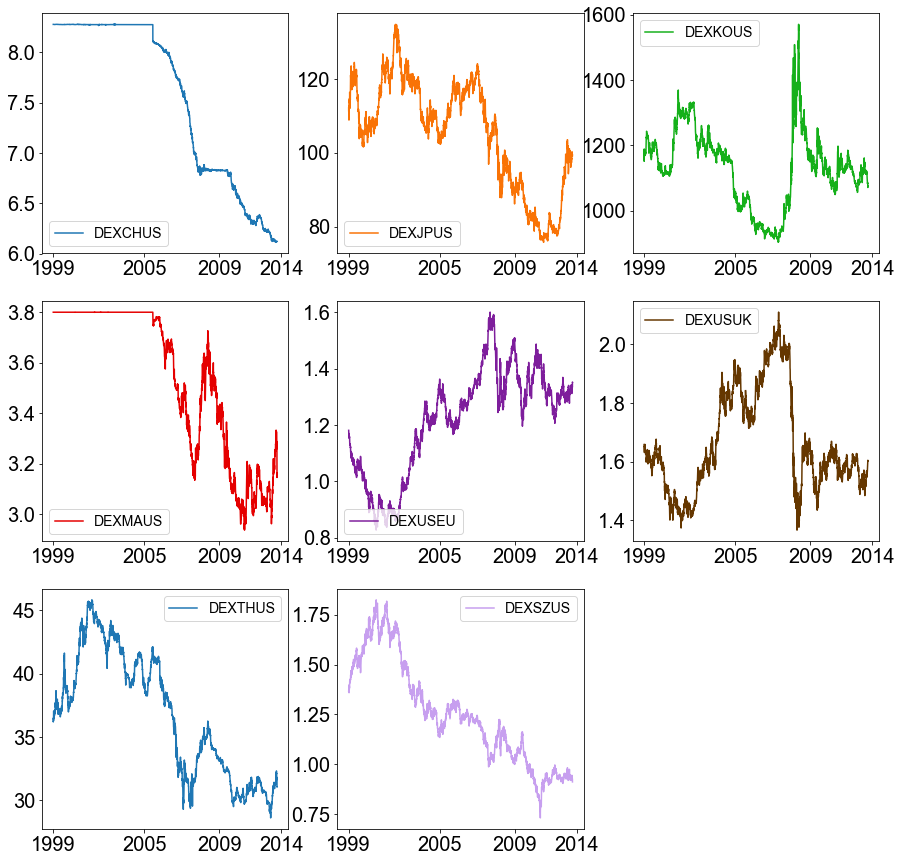

In [4]:
params = {'legend.fontsize': 'x-large',
              'figure.figsize': (15,15),
              'font.family': 'Arial',
              'font.size': 20,
              'axes.labelsize': 24,
              'axes.titlesize': 24,
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'legend.fontsize': 14,
              'legend.loc': 'upper left'}

plt.rcParams.update(params)

year = [19990101, 20050101, 20091208, 20140101]
dates = [dt.datetime.strptime(str(int(date)),'%Y%m%d') for date in year]


plt.subplot(3,3,1)
plt.plot(fx_data[fx_list[0]], label = fx_list[0])
plt.legend(loc = 3)
plt.xticks(dates)

plt.subplot(3,3,2)
plt.plot(fx_data[fx_list[1]], label = fx_list[1], color = 'xkcd:orange')
plt.legend(loc = 3)
plt.xticks(dates)

plt.subplot(3,3,3)
plt.plot(fx_data[fx_list[2]], label = fx_list[2], color = 'xkcd:green')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,4)
plt.plot(fx_data[fx_list[3]], label = fx_list[3], color = 'xkcd:red')
plt.legend(loc = 3)
plt.xticks(dates)

plt.subplot(3,3,5)
plt.plot(fx_data[fx_list[4]], label = fx_list[4], color = 'xkcd:purple')
plt.legend(loc = 3)
plt.xticks(dates)

plt.subplot(3,3,6)
plt.plot(fx_data[fx_list[5]], label = fx_list[5], color = 'xkcd:brown')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,7)
plt.plot(fx_data[fx_list[6]], label = fx_list[6])
plt.legend(loc = 1)
plt.xticks(dates)

plt.subplot(3,3,8)
plt.plot(fx_data[fx_list[7]], label = fx_list[7], color = "xkcd:lavender")
plt.legend(loc = 1)
plt.xticks(dates)

## Converting from USD base to Swiss Franc base

We re-express the dollar-based exchange rates using another currency, the Swiss Franc. This allows currency moves of the dollar to be be used to explain moves in the Yuan. The choice of Swiss Franc is consistent with evaluations with respect to a stable, developed-market currency.

<img src="currency.png">


In [5]:
sf_data = pd.DataFrame()

sf_data["CNY_SFR"] = fx_data["DEXCHUS"]/fx_data["DEXSZUS"]
sf_data["YEN_SFR"] = fx_data["DEXJPUS"]/fx_data["DEXSZUS"]
sf_data["WON_SFR"] = fx_data["DEXKOUS"]/fx_data["DEXSZUS"]
sf_data["MYR_SFR"] = fx_data["DEXMAUS"]/fx_data["DEXSZUS"]

sf_data["EUR_SFR"] = 1.0/(fx_data["DEXUSEU"]*fx_data["DEXSZUS"])
sf_data["GBP_SFR"] = 1.0/(fx_data["DEXUSUK"]*fx_data["DEXSZUS"])

sf_data["THB_SFR"] = fx_data["DEXTHUS"]/fx_data["DEXSZUS"]

sf_data["USD_SFR"] = 1.0/fx_data["DEXSZUS"]

sf_data.head()

,CNY_SFR,YEN_SFR,WON_SFR,MYR_SFR,EUR_SFR,GBP_SFR,THB_SFR,USD_SFR
DATE,,,,,,,,
1999-01-04,6.058320,82.064979,868.944827,2.780623,0.619491,0.441314,26.489097,0.731743
1999-01-05,6.046079,81.166934,851.467796,2.774938,0.620958,0.440811,26.420330,0.730247
1999-01-06,5.977115,81.417846,837.424199,2.743286,0.620417,0.436283,26.349986,0.721917
1999-01-07,5.972589,80.566977,830.267619,2.741109,0.618013,0.437311,26.184808,0.721345
1999-01-08,5.926700,79.828203,840.372226,2.720115,0.619543,0.436342,26.091625,0.715820


In [6]:
sf_list = list(sf_data.columns.values)
print(sf_list)

['CNY_SFR', 'YEN_SFR', 'WON_SFR', 'MYR_SFR', 'EUR_SFR', 'GBP_SFR', 'THB_SFR', 'USD_SFR']


([<matplotlib.axis.XTick at 0x1c187b8860>,
 <a list of 4 Text xticklabel objects>)

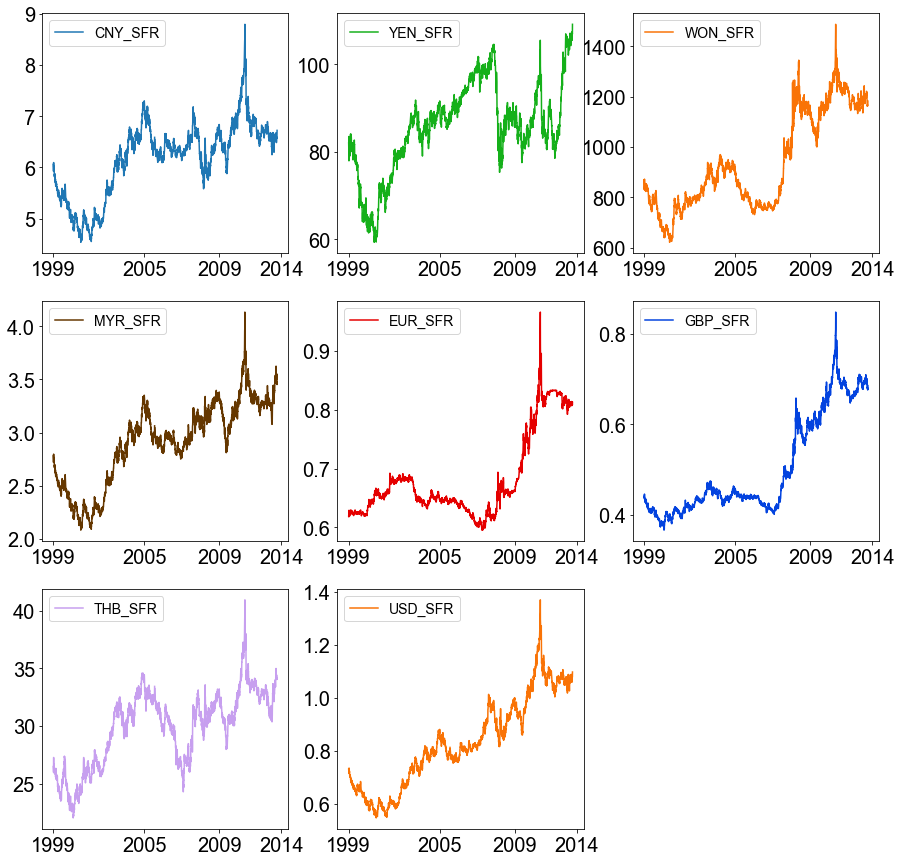

In [7]:
params = {'legend.fontsize': 'x-large',
              'figure.figsize': (15,15),
              'font.family': 'Arial',
              'font.size': 20,
              'axes.labelsize': 24,
              'axes.titlesize': 24,
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'legend.fontsize': 14,
              'legend.loc': 'upper left'}

plt.rcParams.update(params)

year = [19990101, 20050101, 20091208, 20140101]
dates = [dt.datetime.strptime(str(int(date)),'%Y%m%d') for date in year]


plt.subplot(3,3,1)
plt.plot(sf_data[sf_list[0]], label = sf_list[0])
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,2)
plt.plot(sf_data[sf_list[1]], label = sf_list[1], color = 'xkcd:green')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,3)
plt.plot(sf_data[sf_list[2]], label = sf_list[2], color = 'xkcd:orange')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,4)
plt.plot(sf_data[sf_list[3]], label = sf_list[3], color = 'xkcd:brown')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,5)
plt.plot(sf_data[sf_list[4]], label = sf_list[4], color = 'xkcd:red')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,6)
plt.plot(sf_data[sf_list[5]], label = sf_list[5], color = 'xkcd:blue')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,7)
plt.plot(sf_data[sf_list[6]], label = sf_list[6], color = 'xkcd:lavender')
plt.legend(loc = 2)
plt.xticks(dates)

plt.subplot(3,3,8)
plt.plot(sf_data[sf_list[7]], label = sf_list[7], color = 'xkcd:orange')
plt.legend(loc = 2)
plt.xticks(dates)

# Calculating the returns and partitioning the data sets

In [8]:
sf_return = np.log(1.0 + sf_data.pct_change())
sf_return = sf_return.dropna(axis=0)
sf_return.head()

,CNY_SFR,YEN_SFR,WON_SFR,MYR_SFR,EUR_SFR,GBP_SFR,THB_SFR,USD_SFR
DATE,,,,,,,,
1999-01-05,-0.002023,-0.011003,-0.020318,-0.002047,0.002365,-0.001142,-0.002599,-0.002047
1999-01-06,-0.011472,0.003087,-0.016631,-0.011472,-0.000872,-0.010324,-0.002666,-0.011472
1999-01-07,-0.000758,-0.010506,-0.008583,-0.000794,-0.003883,0.002354,-0.006288,-0.000794
1999-01-08,-0.007713,-0.009212,0.012097,-0.007689,0.002472,-0.002218,-0.003565,-0.007689
1999-01-11,0.000513,-0.023916,0.001353,0.000501,0.002234,0.002332,-0.004174,0.000501


## Comparison with the dollar peg

<font size="3"> First, we fit the regression model for the period prior to July 2005 when the Chinese currency was pegged to the US dollar.

In [9]:
sf_ret_before = sf_return['20010101':'20050630']
sf_ret_before.head()

,CNY_SFR,YEN_SFR,WON_SFR,MYR_SFR,EUR_SFR,GBP_SFR,THB_SFR,USD_SFR
DATE,,,,,,,,
2001-01-02,0.007930,0.011187,0.017296,0.007869,-0.000299,0.006399,0.015664,0.007869
2001-01-03,0.003043,-0.000990,-0.002766,0.003115,0.002270,-0.001415,0.001058,0.003115
2001-01-04,-0.005504,0.004934,-0.010726,-0.005601,-0.002958,0.002073,-0.009498,-0.005601
2001-01-05,0.005528,0.011817,0.005363,0.005601,-0.003566,0.001590,-0.000621,0.005601
2001-01-08,-0.003141,-0.005073,-0.004048,-0.003177,0.001975,-0.001776,-0.010369,-0.003177


In [10]:
X = sf_ret_before[['YEN_SFR', 'EUR_SFR', 'GBP_SFR', 'USD_SFR']]
y = sf_ret_before['CNY_SFR']

X1 = sm.add_constant(X)

model = sm.OLS(y, X1)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                CNY_SFR   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.894e+06
Date:                Wed, 25 Mar 2020   Prob (F-statistic):               0.00
Time:                        15:21:47   Log-Likelihood:                 9018.0
No. Observations:                1131   AIC:                        -1.803e+04
Df Residuals:                    1126   BIC:                        -1.800e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -1.17e-07   2.49e-06     -0.047      0.9

<font size="3"> The regression fit identifies the pegging of the Yuan (CNR SFR) to the US Dollar (USD SFR). The R − Squared is nearly 1.0.
Second, we fit the regression model for the first six months following the announcement of the change in currency policy.

In [11]:
sf_ret_2 = sf_return['20050701':'20051231']
sf_ret_2.tail()

,CNY_SFR,YEN_SFR,WON_SFR,MYR_SFR,EUR_SFR,GBP_SFR,THB_SFR,USD_SFR
DATE,,,,,,,,
2005-12-23,-0.002981,-0.004279,-0.005333,-0.002767,-0.000629,0.001155,-0.004042,-0.002820
2005-12-27,-0.000623,0.005759,-0.001436,-0.000205,-0.000068,0.000887,0.001315,-0.000152
2005-12-28,0.001002,0.005677,0.001829,0.000990,-0.000612,0.005739,0.000745,0.000990
2005-12-29,-0.001264,0.000973,-0.005072,-0.000933,0.001379,-0.003096,0.001131,-0.001066
2005-12-30,-0.000467,-0.000211,0.000610,-0.000645,-0.000043,0.003858,-0.000868,-0.000380


In [12]:
X = sf_ret_2[['YEN_SFR', 'EUR_SFR', 'GBP_SFR', 'USD_SFR', 'WON_SFR', 'THB_SFR', 'MYR_SFR']]
y = sf_ret_2['CNY_SFR']

X1 = sm.add_constant(X)

model = sm.OLS(y, X1)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                CNY_SFR   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     314.0
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           3.99e-73
Time:                        15:21:53   Log-Likelihood:                 643.34
No. Observations:                 126   AIC:                            -1271.
Df Residuals:                     118   BIC:                            -1248.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.868      0.3

<font size="3"> During this six-month period, there is evidence of the Yuan departing from a US Dollar peg. The exchange rates with the statsitically significant regression parameters are for the Korean Won (WON SFR) and the Malaysian Ringgit (MYR SFR).
To examine for futher changes in the implicit reference basket, we fit the same model for the annual periods from 2006 through 2012 and for the first 6 months of 2013.

## Comparing the Reference Basket and the Appreciation Rate wrt USD for each year

In [13]:
y_list = ['2006', '2007', '2008', '2009', '2010', '2011', '2012']

euro_coef = []
pound_coef = []
dollar_coef = []
yen_coef = []
won_coef = []
baht_coef = []
ringgit_coef = []
appreciation_rate = []

r_sq = []

for y in y_list:
    
    t_start = y + '0101'
    t_end = y + '1231'
    
    sf_ret_data = sf_return[t_start: t_end]
    
    X = sf_ret_data[['EUR_SFR', 'GBP_SFR', 'USD_SFR', 'YEN_SFR' ,'WON_SFR', 'THB_SFR', 'MYR_SFR']]
    y = sf_ret_data['CNY_SFR']

    X1 = sm.add_constant(X)

    model = sm.OLS(y, X1)
    results = model.fit()
    
    euro_coef.append(results.params[1])
    pound_coef.append(results.params[2])
    dollar_coef.append(results.params[3])
    yen_coef.append(results.params[4])
    won_coef.append(results.params[5])
    baht_coef.append(results.params[6])
    ringgit_coef.append(results.params[7])
    
    apr = np.exp(252*np.log(1.0 + results.params[0])) - 1.0
    
    r_sq.append(results.rsquared)
    appreciation_rate.append(apr)

Next we create a dataframe with all the coefficients and the R-squared

In [15]:
yoy_coefficients = pd.DataFrame()

yoy_coefficients['Year'] = y_list
yoy_coefficients['Euro'] = euro_coef
yoy_coefficients['GBP'] = pound_coef
yoy_coefficients['USD'] = dollar_coef
yoy_coefficients['YEN'] = yen_coef
yoy_coefficients['WON'] = won_coef
yoy_coefficients['BAHT'] = baht_coef
yoy_coefficients['RINGGIT'] = ringgit_coef
yoy_coefficients['Apr Rate'] = appreciation_rate

yoy_coefficients.set_index('Year', inplace=True)

yoy_coefficients

,Euro,GBP,USD,YEN,WON,BAHT,RINGGIT,Apr Rate
Year,,,,,,,,
2006,-0.018412,-0.016932,0.922215,-0.005226,0.029060,-0.008371,0.069094,-0.029119
2007,0.016293,0.004861,0.920066,-0.018471,0.021480,0.001411,0.012267,-0.060529
2008,0.041511,0.016351,0.912481,-0.001018,-0.019230,0.011482,0.073961,-0.072737
2009,-0.015493,0.004148,0.940495,0.005974,-0.001672,0.031020,0.025297,0.001960
2010,0.020725,-0.031598,0.911597,0.001170,0.002656,0.065070,0.023589,-0.023723
2011,-0.000396,0.042966,0.870189,0.007857,-0.025901,0.017428,0.095352,-0.048386
2012,-0.131950,-0.008758,0.906398,-0.005759,0.001777,0.001895,0.110317,-0.004905


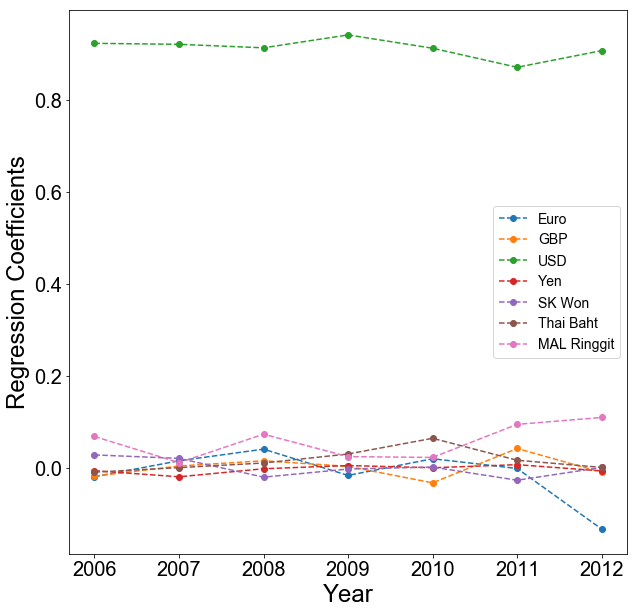

In [56]:
params = {'legend.fontsize': 'x-large',
              'figure.figsize': (10,10),
              'font.family': 'Arial',
              'font.size': 20,
              'axes.labelsize': 24,
              'axes.titlesize': 24,
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'legend.fontsize': 14,
              'legend.loc': 'upper left'}

plt.rcParams.update(params)

plt.plot(yoy_coefficients["Euro"], label = 'Euro', marker = 'o', linestyle = '--')
plt.plot(yoy_coefficients["GBP"], label = 'GBP', marker = 'o', linestyle = '--')
plt.plot(yoy_coefficients["USD"], label = 'USD', marker = 'o', linestyle = '--')
plt.plot(yoy_coefficients["YEN"], label = 'Yen', marker = 'o', linestyle = '--')
plt.plot(yoy_coefficients["WON"], label = 'SK Won', marker = 'o', linestyle = '--')
plt.plot(yoy_coefficients["BAHT"], label = 'Thai Baht', marker = 'o', linestyle = '--')
plt.plot(yoy_coefficients["RINGGIT"], label = 'MAL Ringgit', marker = 'o', linestyle = '--')

plt.ylabel('Regression Coefficients')
plt.xlabel('Year')

plt.legend(loc = 'best')

<font size="4"> These fitted regression models demonstrate that the statistical evidence for the underlying reference basket of currencies changes from year to year. The high R-squared value of the linear fit demonstrates how the different exhange rates are significant predictors of the daily change in the Yuan exchange rate for different years.

Text(0.5,0,'Year')

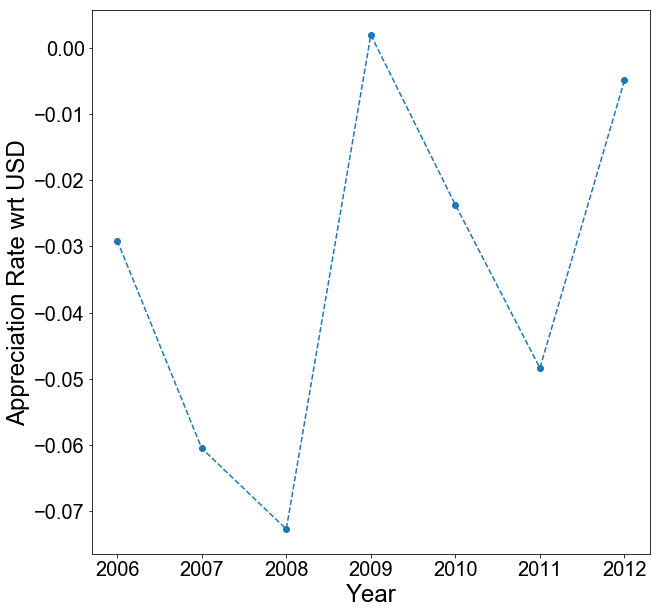

In [16]:
params = {'legend.fontsize': 'x-large',
              'figure.figsize': (10,10),
              'font.family': 'Arial',
              'font.size': 20,
              'axes.labelsize': 24,
              'axes.titlesize': 24,
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'legend.fontsize': 14,
              'legend.loc': 'upper left'}

plt.rcParams.update(params)

plt.plot(yoy_coefficients["Apr Rate"], marker = 'o', linestyle = '--')

plt.ylabel('Appreciation Rate wrt USD')
plt.xlabel('Year')

## Additional features of exchange rate regime modelling using the reference basket implied by the data for 2012

In [17]:
t_start = '20120101'

t_end = '20121231'
    
sf_ret_data = sf_return[t_start: t_end]
    
X = sf_ret_data[['EUR_SFR', 'GBP_SFR', 'USD_SFR', 'YEN_SFR' ,'WON_SFR', 'THB_SFR', 'MYR_SFR']]

y = sf_ret_data['CNY_SFR']

X1 = sm.add_constant(X)

model = sm.OLS(y, X1)

results = model.fit()

In [19]:
sf_ret_data["Basket"] = results.params[0] +  sf_ret_data["EUR_SFR"]*results.params[1] +  sf_ret_data["GBP_SFR"]*results.params[2] + \
                        sf_ret_data["USD_SFR"]*results.params[3] + sf_ret_data["YEN_SFR"]*results.params[4] + \
                        sf_ret_data["WON_SFR"]*results.params[5] + sf_ret_data["THB_SFR"]*results.params[6] + \
                        sf_ret_data["MYR_SFR"]*results.params[7] 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(-0.08, 0.06)

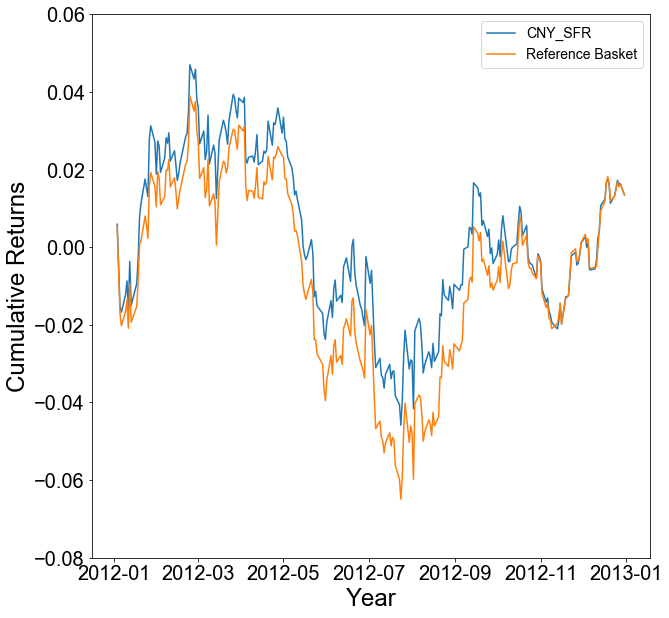

In [36]:
params = {'legend.fontsize': 'x-large',
              'figure.figsize': (10,10),
              'font.family': 'Arial',
              'font.size': 20,
              'axes.labelsize': 24,
              'axes.titlesize': 24,
              'xtick.labelsize': 20,
              'ytick.labelsize': 20,
              'legend.fontsize': 14,
              'legend.loc': 'upper left'}

plt.rcParams.update(params)

plt.plot(sf_ret_data["CNY_SFR"].cumsum(), label = 'CNY_SFR')
plt.plot(sf_ret_data["Basket"].cumsum(), label = 'Reference Basket')

plt.ylabel('Cumulative Returns')
plt.xlabel('Year')

plt.legend(loc = 1)

plt.ylim(-0.08, 0.06)

Note how closely the reference basket tracks the Yuan. This is to be expected given the high R−squared of the regression